Analysis of RTM using SVD method
===

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import ImageGrid
from numpy.lib.format import open_memmap
from raysect.optical import World

from cherab.phix.tools import profile_1D_to_2D
from cherab.phix.tools.raytransfer import import_phix_rtc
from cherab.phix.tools.visualize import set_cbar_format, set_norm, show_phix_profiles

RTM_DIR = Path().cwd().parent.parent.parent / "output" / "RTM" / "2022_12_13_00_49_29"

world = World()
rtc = import_phix_rtc(world)

Compare $L=\text{Laplacian}$ vs $L=I$
---
Let us see the difference of SVD components between $L=\text{laplacian}$ and $L=I$.

Load SVD matrices and values with $L=\text{Laplacian}$

In [2]:
u = open_memmap(RTM_DIR / "w_laplacian" / "u.npy")
s = open_memmap(RTM_DIR / "w_laplacian" / "s.npy")
vh = open_memmap(RTM_DIR / "w_laplacian" / "vh.npy")
L_inv_V = open_memmap(RTM_DIR / "w_laplacian" / "L_inv_V.npy")

Load SVD matrices and values without Laplacian i.e. $L=I$

In [3]:
u_w = open_memmap(RTM_DIR / "wo_laplacian" / "u.npy")
s_w = open_memmap(RTM_DIR / "wo_laplacian" / "s.npy")
vh_w = open_memmap(RTM_DIR / "wo_laplacian" / "vh.npy")

Singular values: $\sigma_i$
---

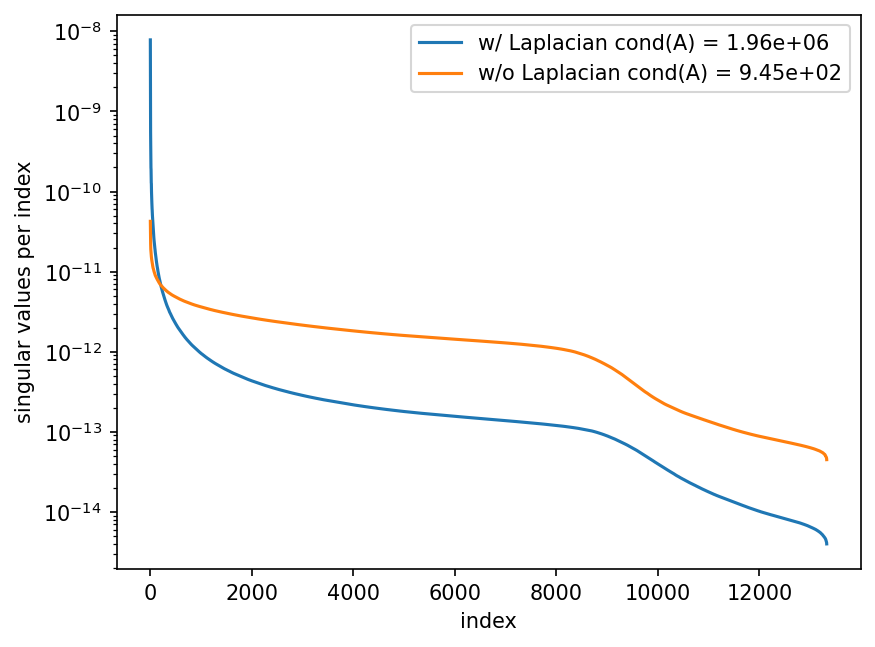

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.semilogy(s, label=f"w/ Laplacian cond(A) = {s.max() / s.min():.2e}")
ax.semilogy(s_w, label=f"w/o Laplacian cond(A) = {s_w.max() / s_w.min():.2e}")
ax.set_xlabel("index")
ax.set_ylabel("singular values per index")
ax.legend();

Basis vector: $\tilde{V} = L^{-1}v_i$
---
These vectors play an important role with tomographic reconstruction because the inverse solution
consists of the series of vector $L^{-1}v_i$, which is regarded as a basis vector of the solution.

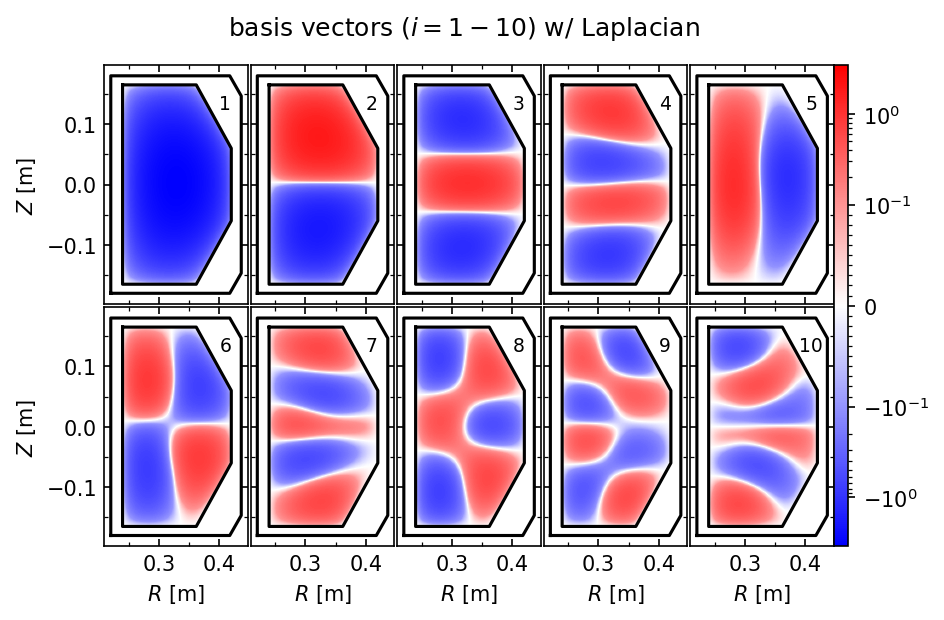

In [5]:
n_basis = 10
nrow = 2

fig = plt.figure(dpi=150)
profile2ds = []
for i in range(n_basis):
    profile2ds.append(profile_1D_to_2D(L_inv_V[:, i], rtc))


fig, grids = show_phix_profiles(
    profile2ds,
    fig=fig,
    nrow_ncols=(nrow, n_basis // nrow),
    rtc=rtc,
    clabel="",
    cmap="bwr",
    plot_mode="symlog",
    linear_width=0.1,
)

for i, ax in enumerate(grids):
    ax.text(
        0.41,
        0.15,
        f"{i+1}",
        fontsize=9,
        color="k",
        va="top",
        ha="center",
    )

fig.suptitle("basis vectors $(i=1-10)$ w/ Laplacian", y=0.90);

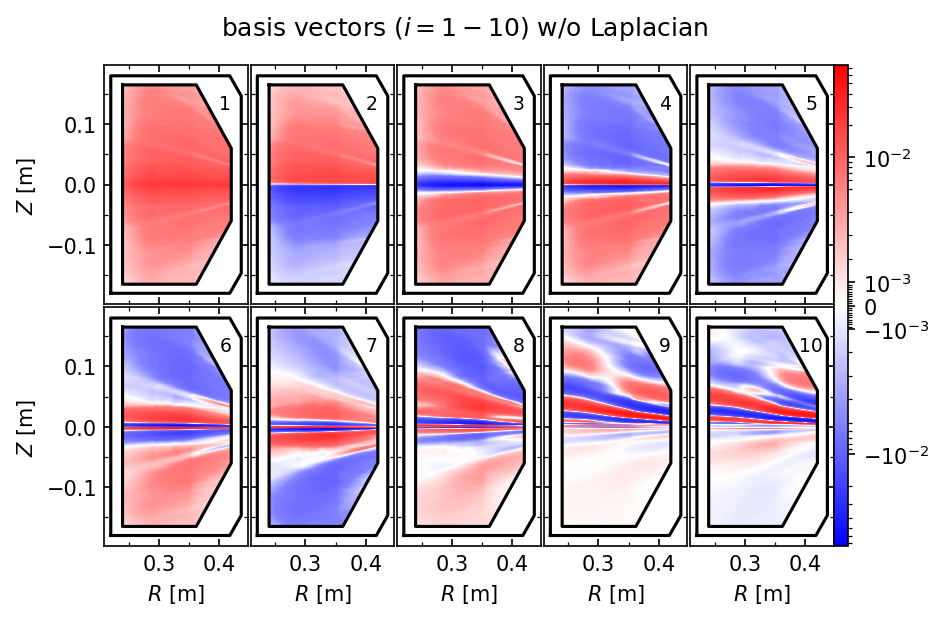

In [6]:
n_basis = 10
nrow = 2

fig = plt.figure(dpi=150)
profile2ds = []
for i in range(n_basis):
    profile2ds.append(profile_1D_to_2D(vh_w[i, :], rtc))

fig, grids = show_phix_profiles(
    profile2ds,
    fig=fig,
    nrow_ncols=(nrow, n_basis // nrow),
    rtc=rtc,
    clabel="",
    cmap="bwr",
    plot_mode="symlog",
    linear_width=5e-3,
)

for i, ax in enumerate(grids):
    ax.text(
        0.41,
        0.15,
        f"{i+1}",
        fontsize=9,
        color="k",
        va="top",
        ha="center",
    )

fig.suptitle("basis vectors $(i=1-10)$ w/o Laplacian", y=0.90);

Left-singular vectors: $u_i$
---
These vectors are related to the measured camera images.
We can find the Laplacian effect in them as well.

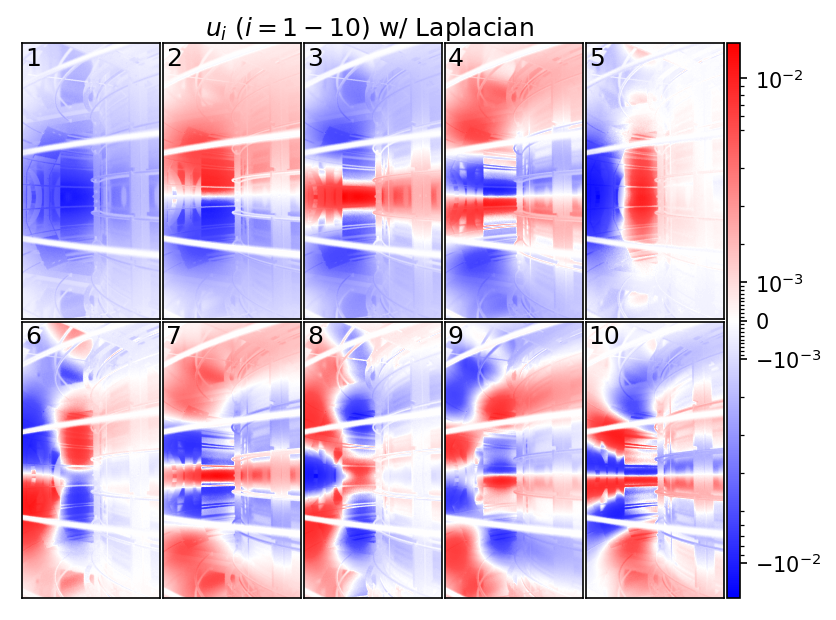

In [7]:
n_basis = 10
cmap = "bwr"
linear_width=5e-3

images = []
for i in range(n_basis):
    images.append(u[:, i].reshape((256, 512)).T)

vmin = min([image.min() for image in images])
vmax = max([image.max() for image in images])

norm = set_norm("symlog", vmin, vmax, linear_width=linear_width)

fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5), cbar_mode="single")
for i, image in enumerate(images):
    grid[i].imshow(image, cmap=cmap, norm=norm)
    grid[i].text(5, 5, f"{i+1}", fontsize=12, color="k", va="top")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

mappable = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable=mappable, cax=grid.cbar_axes[0])
set_cbar_format(cbar.ax, "symlog", linear_width=linear_width)

fig.suptitle("$u_i\\ (i=1-10)$ w/ Laplacian", y=0.92);

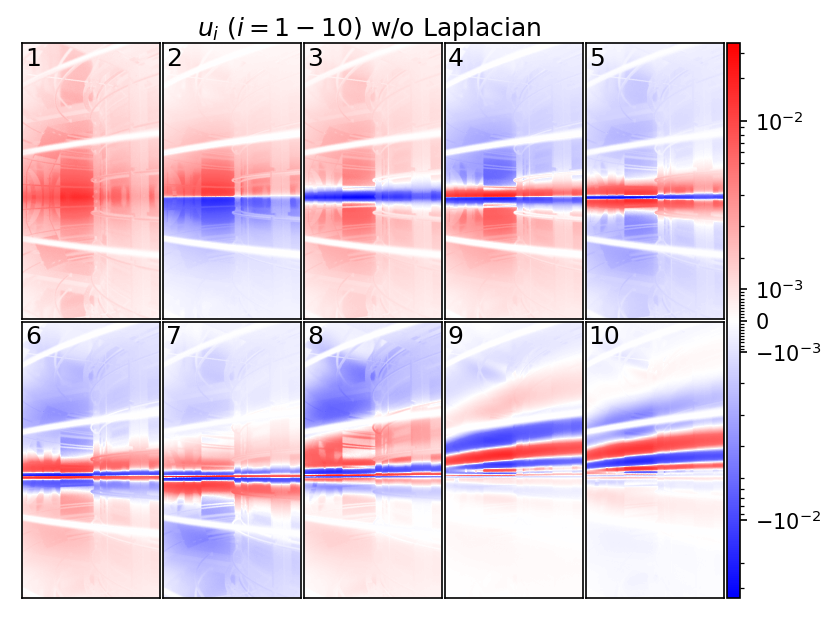

In [8]:
n_basis = 10
cmap = "bwr"
linear_width=5e-3

images = []
for i in range(n_basis):
    images.append(u_w[:, i].reshape((256, 512)).T)

vmin = min([image.min() for image in images])
vmax = max([image.max() for image in images])

norm = set_norm("symlog", vmin, vmax, linear_width=linear_width)

fig = plt.figure(dpi=150)
grid = ImageGrid(fig, 111, (2, 5), cbar_mode="single")
for i, image in enumerate(images):
    grid[i].imshow(image, cmap=cmap, norm=norm)
    grid[i].text(5, 5, f"{i+1}", fontsize=12, color="k", va="top")
    grid[i].set_xticks([])
    grid[i].set_yticks([])

mappable = ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable=mappable, cax=grid.cbar_axes[0])
set_cbar_format(cbar.ax, "symlog", linear_width=linear_width)

fig.suptitle("$u_i\\ (i=1-10)$ w/o Laplacian", y=0.92);